# Demo de implementación de un Algoritmo Memético (Meme Algorithm) junto de Colonia de Abejas para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
!pip install deap

1) Importar librerías:

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import copy
import operator

from deap import base
from deap import creator
from deap import tools

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [3]:
# Espacio  de búsqueda
CANT_MAXIMOS_LOCALES = 3
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 25

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1 

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True

#  Área de las Abejas Exploradoras
RADIO_AREA_EXPLORADORA = 50
PORC_RED_AREA_EXPLORADORA = 0.5
MIN_RADIO_AREA_EXPLORADORA = 2
CANT_ABEJAS_OBRERAS_RECL_ELITE = 15

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


2) Inicializar objetos de DEAP para utilizar e indicar Operadores Genéticos:

In [4]:
### clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


Clase Mapa de Búqueda definida


In [5]:
### clase ABEJA

class Abeja(object):
    
    def __init__(self, mapa=None, radioArea=0):
        
        if mapa == None:
            self.pos = []
            self.radio = 0
            self.valor = -9999
        else:        
            self.pos = [random.randint(mapa.limMin, mapa.limMax) for _ in range(2)]
            self.valor = mapa.funcHeuristica(self.pos)
            self.radio = radioArea

    def _reset(self):
        self.pos = []
        self.radio = 0
        self.valor = -9999

    @property
    def heuristica(self):
        return self.valor

    @property
    def posicion(self):
        return self.pos    

    @property
    def tieneArea(self):
        return self.radio>0        

    def reclutarObreras(self, mapa, cantObrerasReclutadas, \
                        radioAreaExpl=RADIO_AREA_EXPLORADORA, \
                        porcRedAreaExpl = PORC_RED_AREA_EXPLORADORA, \
                        minAreaExpl=MIN_RADIO_AREA_EXPLORADORA):
        
        # Si el radio del área es nulo, no se generan
        if self.radio <= 0:
            return []

        obrerasReclutadasNuevas = []
        algunaObreraMejor = False
        for i in range(cantObrerasReclutadas):

              # Crea una nueva abeja a la que le asigna una posción relativa a la exploradora padre
              # y luego calcula su herística
              nOb = Abeja()
              for i in range(len(self.pos)):
                  nOb.pos.append( random.randint(int(self.pos[i]-self.radio), int(self.pos[i]+self.radio)) )
              nOb.valor = mapa.funcHeuristica(nOb.pos)
              
              if nOb.valor > self.valor:
                  # si la nueva obra es mejor que la padre, 
                  #    pasa a ser una exploradora
                  nOb.radio = radioAreaExpl
                  algunaObreraMejor = True

              obrerasReclutadasNuevas.append( nOb )
        
        if not algunaObreraMejor:
                # Cuando ninguna obrera es mejor, 
                #     se reduce el área de la abeja exploradora 
                self.radio = self.radio * (1-porcRedAreaExpl)
                if self.radio <= minAreaExpl:
                    self.radio = 0

        return obrerasReclutadasNuevas

    def hacerExploradoraArea(self, radioArea):
        self.radio = radioArea
        return self.radioArea

    def cambiarPosicion(self, mapa, nuevaPosicion):
        self.pos = nuevaPosicion
        self.valor = mapa.funcHeuristica(self.pos)
        return self.valor

print("\nClase Abeja definida")


Clase Abeja definida


In [6]:
## Inicializa el mapa de búsqueda

# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

# Muestra su información
mapa.printInformacion()


** Máximos Generados:  4
  --> [759, -125] {  60  } 
  --> [-36, -41] {  18  } 
  --> [-87, 322] {  77  } 
  --> [420, 297] {  6  } 

** Posición Máximo Óptimo:  [-87, 322]  {  77  } **




In [7]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

# Registrar tipo de Selección a aplicar con sus parámetros
#toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("select", tools.selRoulette)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", tools.cxTwoPoint)

# Define la función de OPTIMIZACIÓN 
#           que usa un ciclo del Algortimo de Colonia de Abjeas
# Recibe como parámetro el individuo a mutar y el mapa de búsqueda
# Devuelve el individuo optimizado 
def OptimizarPos(individual, mapa, radioAreaExpl, cantAbejasReclutar):

    # crea la abeja exploradora en la posición del indivio
    b = Abeja(mapa, radioArea=radioAreaExpl)
    b.cambiarPosicion(mapa, individual)

    # realiza la reclutación de abejas obreras
    reclObreras = b.reclutarObreras(mapa, cantAbejasReclutar)

    # evalúa las abejas reclutadas con la original  para determinar la mejor
    reclObreras.append( b )
    rankingAbejas = sorted([b for b in reclObreras], key=operator.attrgetter('heuristica'), reverse=True)
    mejorAbeja = rankingAbejas[0]

    # actualiza el individuo con la mejor abeja encontrada
    for i in range(len(individual)):
          individual[i] = mejorAbeja.posicion[i]

    return individual,   


# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", OptimizarPos, mapa=mapa, radioAreaExpl=RADIO_AREA_EXPLORADORA, cantAbejasReclutar=CANT_ABEJAS_OBRERAS_RECL_ELITE)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


3) Especificar Estructura del Cromosoma y Función de Aptitud:

In [8]:
### FUNCIÓN DE APTITUD

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):

    return mapa.funcHeuristica(individuo),
    
# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")


Función de Aptitud definida


In [9]:
### ESTRUCTURA DEL CROMOSOMA

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son float correspondiente a las posiciones
toolbox.register("attr_int", random.randint, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ) 

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Cromosoma definido


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [10]:
## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra):
    
    auxMax = indivPobla[0].fitness.values[0]
    auxMin = indivPobla[0].fitness.values[0]
    auxSum = indivPobla[0].fitness.values[0]
    auxBestInd = indivPobla[0]
    for ind in indivPobla[1:]:

        apt = ind.fitness.values[0]
        auxSum = auxSum + apt

        if apt > auxMax:
            auxMax = apt
            auxBestInd = ind

        if apt < auxMin:
            auxMin = apt

    auxProm = auxSum / len(indivPobla)

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd)
        print("   Max: ", auxMax, " / Promedio: ", round(auxProm,2), " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin

print("\nFunción {CalculoEstadisticas} definida")   


Función {CalculoEstadisticas} definida


In [11]:
#@title
## EJECUCIÓN DE LA CORRIDA

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

# vectores auxiliares 
ciclo = 1    
ciclosMaxIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)
ciclosMaxIndiv.append( copy.deepcopy(auxBestInd) )
ciclosMaxAptitud.append( auxMax )
ciclosPromAptitud.append( auxProm )
ciclosMinAptitud.append( auxMin )

        # criterio de paro
while (ciclo < CANT_CICLOS):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values

    # Realiza la Optimizacion
    for opt in indivHijos:
            toolbox.mutate(opt)
            del opt.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos optimizados
    indivPobla[:] = indivHijos
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)
    ciclosMaxIndiv.append( copy.deepcopy(auxBestInd) )
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

mejorCiclo = np.argmax( ciclosMaxAptitud )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
mejorCiclo = np.argmax( ciclosMaxAptitud )
print("== Mejor Individuo de la Corrida:", ciclosMaxIndiv[mejorCiclo], " { ", ciclosMaxAptitud[mejorCiclo], " } generado en el ciclo ", mejorCiclo," ==")


-- Ciclo  0 --
 Mejor Individuo: [-149, 170]
   Max:  60.58415399682368  / Promedio:  9.82  / Min:  0.0

-- Ciclo  1 --
 Mejor Individuo: [-109, 289]
   Max:  73.03389359698961  / Promedio:  22.19  / Min:  0.0

-- Ciclo  2 --
 Mejor Individuo: [-120, 250]
   Max:  69.07977273053355  / Promedio:  35.36  / Min:  0.0

-- Ciclo  3 --
 Mejor Individuo: [-87, 220]
   Max:  66.8  / Promedio:  43.88  / Min:  0.0

-- Ciclo  4 --
 Mejor Individuo: [-113, 268]
   Max:  71.00667037449132  / Promedio:  44.57  / Min:  9.443715759747109

-- Ciclo  5 --
 Mejor Individuo: [-94, 309]
   Max:  75.52351769397666  / Promedio:  44.68  / Min:  0.0

-- Ciclo  6 --
 Mejor Individuo: [-83, 316]
   Max:  76.2788897449072  / Promedio:  41.85  / Min:  11.979202710603852

-- Ciclo  7 --
 Mejor Individuo: [-65, 198]
   Max:  64.40635080685507  / Promedio:  36.73  / Min:  0.0

-- Ciclo  8 --
 Mejor Individuo: [-47, 222]
   Max:  66.229670385731  / Promedio:  49.11  / Min:  7.603365929301926

-- Ciclo  9 --
 Mejor In

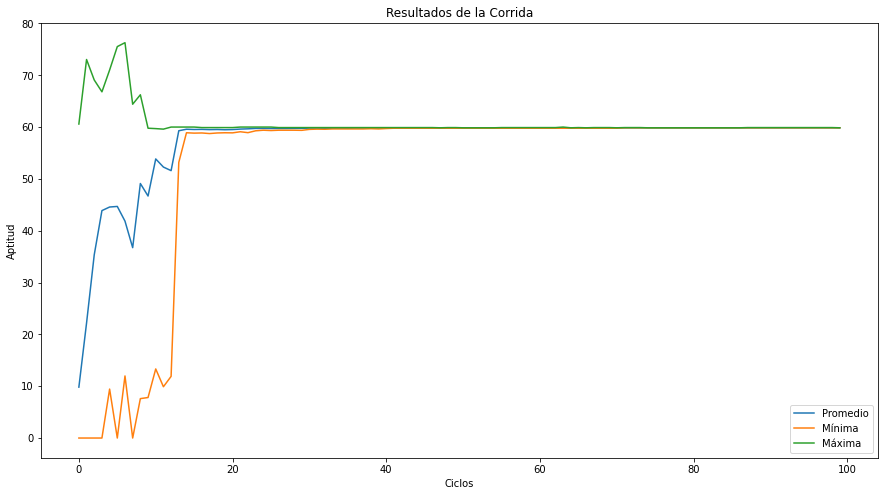

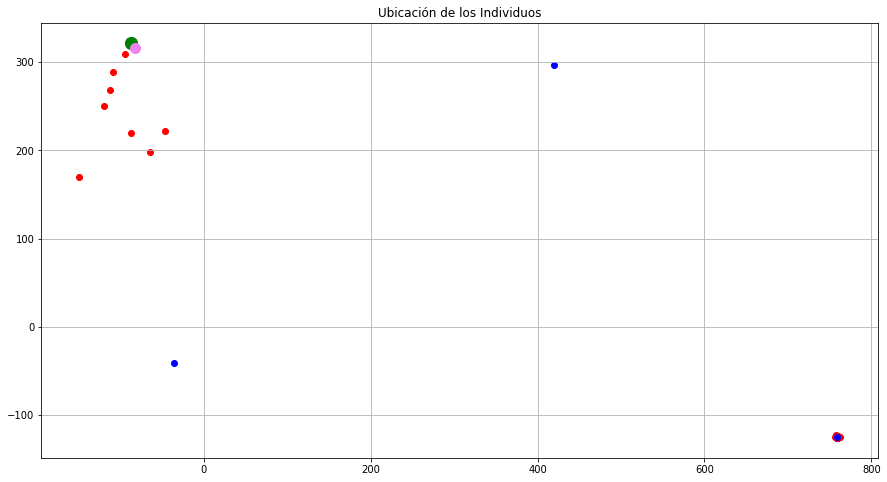

In [13]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.show()


## MOSTRAR GRAFICO DE LA UBICACION DE LOS PUNTOS 
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones del mejor individuo de cada ciclo
for ind in ciclosMaxIndiv:
  plt.scatter(ind[0], ind[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
  if vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')
plt.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)   

## --en Violeta: Individuo mejor ubicado
plt.scatter(ciclosMaxIndiv[mejorCiclo][0], ciclosMaxIndiv[mejorCiclo][1], color='violet', s=100)

plt.title('Ubicación de los Individuos')
#plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
#plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
